In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import mitdeeplearning as mdl
import tensorflow as tf
from tensorflow.keras import layers, models

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [ ]:

import os

#sebelumnya tidak begini tapi minjam template Resnet
BASE_DIR = "dataset"
tr_dir = os.path.join(BASE_DIR, "train")
vl_dir   = os.path.join(BASE_DIR, "validation")
ts_dir  = os.path.join(BASE_DIR, "test")

input_dir = "input"

def load_dataset(directory, img_size=(224,224), batch_size=32, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle
    )
    return ds


train_ds = load_dataset(tr_dir, batch_size=90)
val_ds = load_dataset(vl_dir, batch_size=10, shuffle=False)
test_ds = load_dataset(ts_dir, batch_size=10, shuffle=False)

input_ds = load_dataset(input_dir, batch_size=90)

class_names = train_ds.class_names
print("Kelas:", class_names)

val_ds = val_ds.map(lambda x, y: (x/255.0, y))
test_ds = test_ds.map(lambda x, y: (x/255.0, y))

Found 332 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 41 files belonging to 4 classes.
Kelas: ['gudeg', 'gulai', 'rendang', 'soto']


In [ ]:
# Mengecek jumlah file per kelas meminjam template notebook Resnet lain
def count_images_in_dir(dirpath):
    counts = {}
    if not os.path.exists(dirpath):
        print(f"Directory not found: {dirpath}")
        return counts
    for cls in sorted(os.listdir(dirpath)):
        cls_path = os.path.join(dirpath, cls)
        if os.path.isdir(cls_path):
            counts[cls] = sum([1 for _ in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, _))])
    return counts

print("Train counts:", count_images_in_dir(tr_dir))
print("Validation counts:", count_images_in_dir(vl_dir))
print("Test counts:", count_images_in_dir(ts_dir))

Train counts: {'gudeg': 80, 'gulai': 80, 'rendang': 82, 'soto': 90}
Validation counts: {'gudeg': 10, 'gulai': 10, 'rendang': 10, 'soto': 10}
Test counts: {'gudeg': 10, 'gulai': 10, 'rendang': 10, 'soto': 10}


In [32]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([ #untuk menangani masalah overfitting karena telah terjadi sebelumnya. dengan menggunakan augmentasi data untuk memberi variasi data
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (x/255.0, y))


In [ ]:
def visualize(dataset, num_images=20):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        rand_i = np.random.choice(len(images), num_images, replace=False) #buat pengambilan index acak
        for i in range(len(rand_i)):
            idx = rand_i[i]
            plt.subplot(4, 5, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[idx].numpy())
            label_index = int(labels[idx].numpy())
            plt.xlabel(class_names[label_index])
    plt.show()

def visualize_pred(dataset,num_images=20):
    plt.figure(figsize=(15, 15))
    for images, labels in input_ds.take(1):
        predictions = model.predict(images)
        pred_classes = tf.argmax(predictions, axis=1)
        conf_scores = tf.reduce_max(tf.nn.softmax(predictions, axis=1), axis=1)

        rand_i = np.random.choice(images.shape[0], 20, replace=False)

        for i in range(len(rand_i)):
            idx = rand_i[i]
            plt.subplot(4, 5, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[idx].numpy().astype("uint8"))
            true_label = class_names[int(labels[idx])]
            pred_label = class_names[int(pred_classes[idx])]
            confidence = conf_scores[idx].numpy() * 100
            plt.xlabel(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)")

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

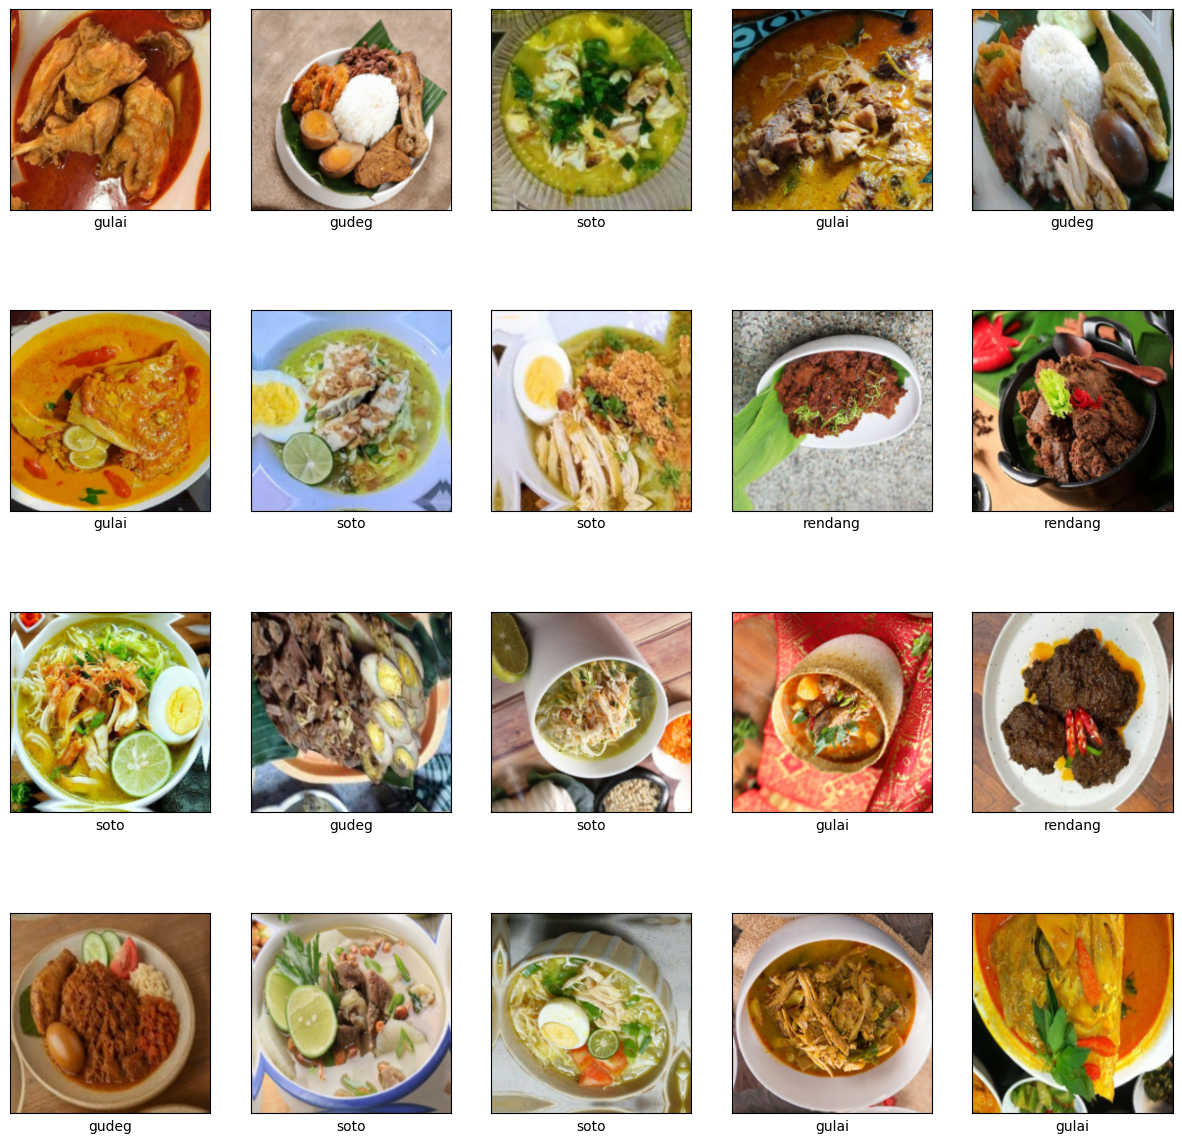

In [ ]:
visualize(train_ds)


In [6]:
model = models.Sequential([ # 3 Conv2D karena databasenya makanan 
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3), 
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

C:\Users\Pongo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005) #sebelumnya 0.001(default) tapi hasilnya overfitting

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2330 - loss: 2.8863 - val_accuracy: 0.2500 - val_loss: 1.3870
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - accuracy: 0.2544 - loss: 1.3975 - val_accuracy: 0.4500 - val_loss: 1.3737
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - accuracy: 0.3211 - loss: 1.3542 - val_accuracy: 0.3250 - val_loss: 1.2736
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - accuracy: 0.3916 - loss: 1.2642 - val_accuracy: 0.4500 - val_loss: 1.1091
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 461ms/step - accuracy: 0.5825 - loss: 1.0843 - val_accuracy: 0.6500 - val_loss: 0.9456
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - accuracy: 0.5873 - loss: 1.0042 - val_accuracy: 0.7250 - val_loss: 0.8516
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 437ms/step - accuracy: 0.6597 - loss: 0.8684 - val_accuracy: 0.7250 - val_loss: 0.8400
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 435ms/step - accuracy: 0.6341 - loss: 0.8403 - val_accuracy: 0.75

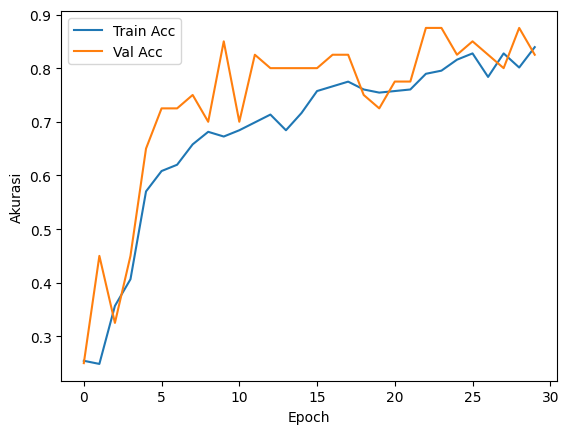

In [8]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

test_loss, test_acc = model.evaluate(test_ds)
print("Akurasi :", test_acc)

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()


   accuracy      loss  val_accuracy  val_loss
0  0.254386  2.437648         0.250  1.387000
1  0.248538  1.390130         0.450  1.373656
2  0.356725  1.335914         0.325  1.273629
3  0.406433  1.251649         0.450  1.109056
4  0.570175  1.067388         0.650  0.945636


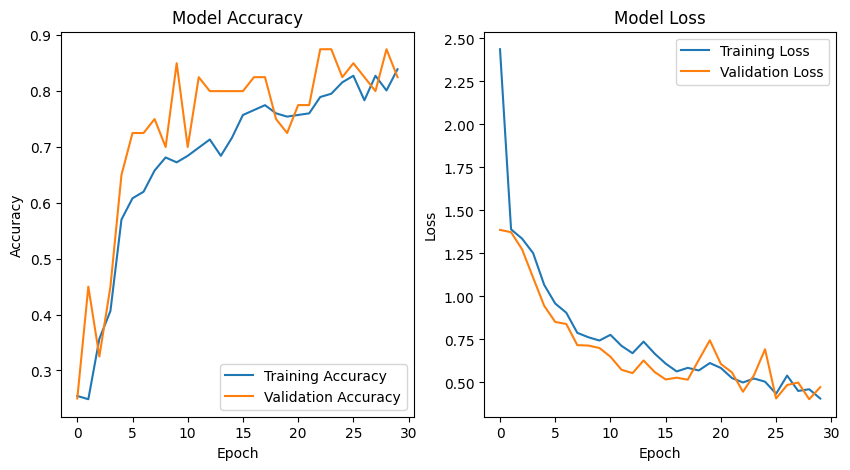

In [ ]:
import pandas as pd

df_history = pd.DataFrame(history.history)
print(df_history.head())
plt.figure(figsize=(10,5))

# Accuracynya
plt.subplot(1, 2, 1)
plt.plot(df_history['accuracy'], label='Training Accuracy')
plt.plot(df_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Lossnya
plt.subplot(1, 2, 2)
plt.plot(df_history['loss'], label='Training Loss')
plt.plot(df_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 


<Figure size 1500x1500 with 0 Axes>

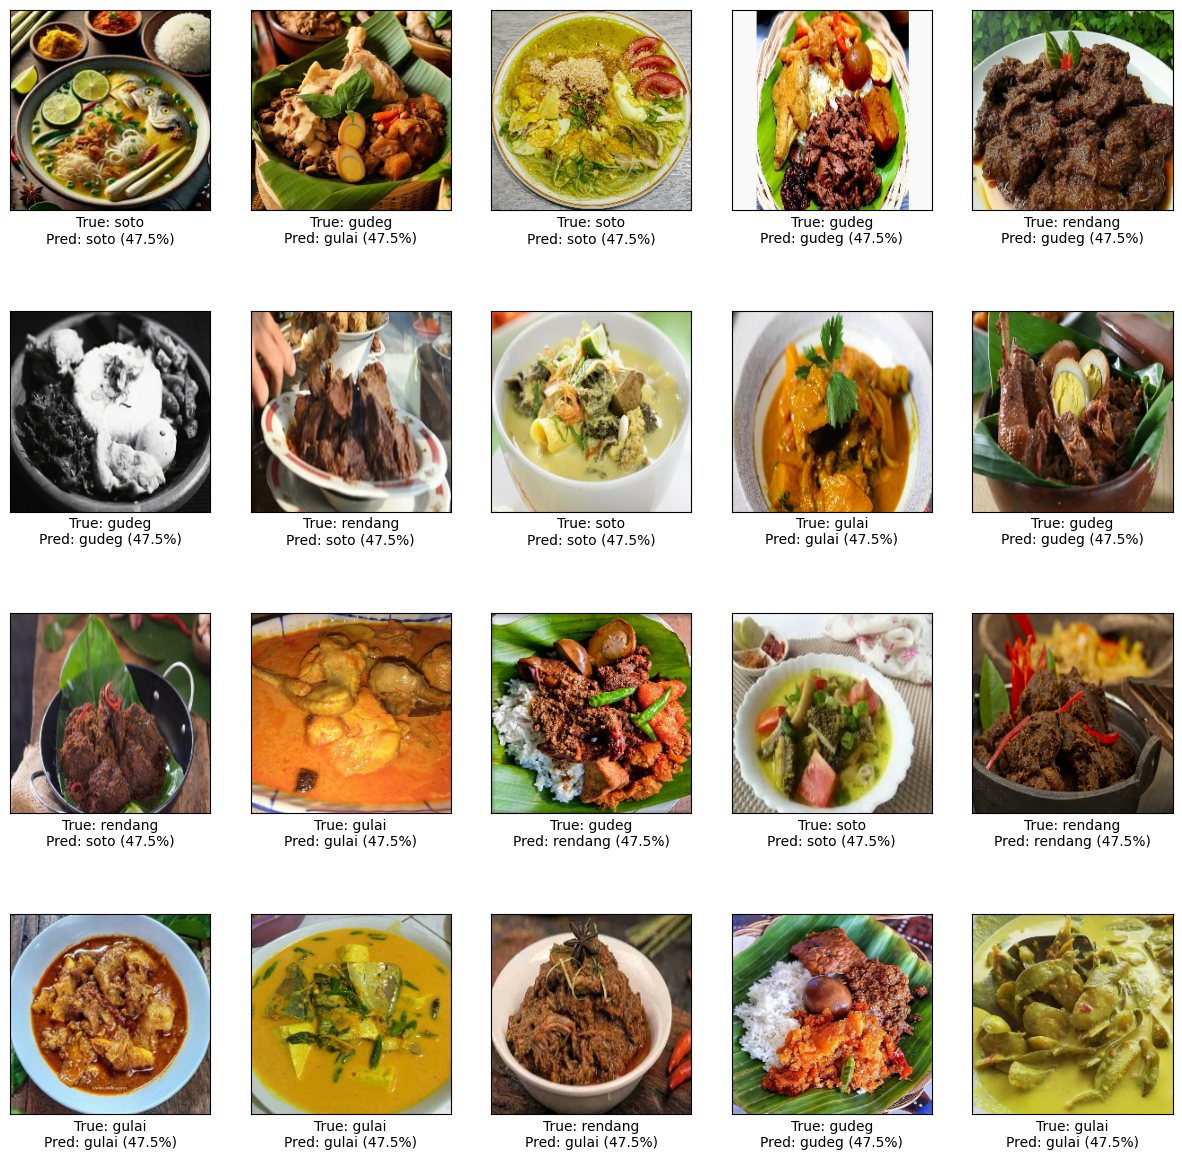

In [ ]:
visualize_pred(input_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


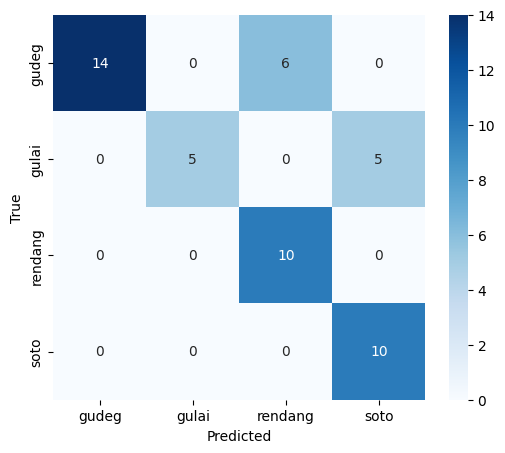

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
model.save_weights("Custom_A_AlekSnack.h5")



